In [23]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import time
import numpy as np
import matplotlib.pyplot as plt


def round_up(num):
    """
    Returns the multiple of ten after `num`.
    """
    return (10 - num % 10) + num


class Chromosome:
    """
    Implements basic structure for
    storing and operating on algorithm data.
    """
    def __init__(self, size=0, alphabet=[]):
        if not size:
            self.genes = np.ndarray(size)
        else:
            np.random.seed()
            self.genes = np.random.choice(alphabet, size)
        
        self.fitness = 0

    def __str__(self):
        return "".join(list(map(str, self.genes)))

    def calculate_fitness(self, target):
        """
        Calculates fitness of the individual
        given a target.
        """
        hits = 0
        for i, j in zip(self.genes, target):
            if i == j:
                hits += 1
        self.fitness = (hits * 100) / len(target)


class Population:
    """
    Implements basic operations on a set
    of Chromosome objects.
    """

    def __init__(self, alphabet, psize, csize):
        """
        :param alphabet: Symbols used to generate the chromosomes.
        :param psize: Population size.
        :param csize: Chromosome size.
        """
        self.alphabet = alphabet
        self.psize = psize
        self.csize = csize
        self.population = self._gen_pop(psize, csize, alphabet)

    def __str__(self):
        return "\n".join(map(str, self.population))

    def update(self, target):
        """
        Updates the fitness value for every
        individual in the population based on
        the given target.
        """
        for c in self.population:
            c.calculate_fitness(self.target)

    def get_fitness(self):
        """
        Returns the fitness value for every
        individual in the population.
        """
        return [c.fitness for c in self.population]

    def sort(self):
        """
        Sorts the elements of the population
        based on its fitness values.
        """
        self.population = sorted(self.population, key=lambda chromosome: chromosome.fitness)

    def renew(self):
        """
        Eliminates the half of the population
        with the worst fitness values, replacing
        them with a list of new randomly generated
        individuals.
        """
        index = int(len(self.population) / 2)
        self.population = self._gen_pop(index, self.csize, self.alphabet) \
                          + self.population[index:]

    def _gen_pop(self, psize, csize, alphabet):
        """
        Generates a new list of individuals randomly.

        :param psize: Size of the population to be generated.
        :param csize: Size of the Chromosome to be generated.
        :param alphabet: Set of symbols used to generate the population individuals.
        :return: A list of randomly generated individuals.
        """
        return [Chromosome(csize, alphabet) for _ in range(psize)]


class Randomwalk(Population):
    """
    Implements the steps of a Randomwalk
    algorithm based on the methods of the
    Population class.
    """
    def __init__(self, alphabet, target, psize, gcounter, tcounter=30):
        """

        :param alphabet: Symbols used to generate the population individuals.
        :param target: The target to be achieved by the algorithm.
        :param psize: Population size.
        :param gcounter: Max generations without change in best fitness permited.
        :param tcounter: Number of times the algorithm is executed.
        """
        self.alphabet = alphabet
        self.target = target
        self.csize = len(self.target)
        self.psize = psize
        self.gcounter = gcounter
        self.tcounter = tcounter

    def run(self, verbose=False):
        """
        Routine that combines the methods of the
        base class (Population) to perform the algorithm.

        :param verbose: If **True**, logs info during the execution of the algorithm.
        """

        # Initiate a list to receive the best fitness values
        # achieved per execution.
        self.best_scores = []

        # Initiate a list to receive the number of generations
        # spent per execution.
        self.generations = []

        if verbose:
            then = time.time()

            print("{!s} started...".format(type(self).__name__))
            print("Target: {!s}".format("".join(map(str, self.target))))
            print("Population size: {!s}".format(self.psize))
            print("Total executions: {!s}".format(self.tcounter))
            print("Max generations without change: {!s}\n".format(self.gcounter))

        # Runs the algorithm tcounter times.
        for i in range(self.tcounter):

            # Initiates the population and updates its fitness values
            # based on a given target.
            self.population = self._gen_pop(self.psize, self.csize, self.alphabet)
            self.update(self.target)

            # Initiates a list to receive the best fitness values
            # achieved per generation.
            scores = []

            j = 0  # Holds the value of the best fitness per generation.
            k = 1  # Holds the current generation.
            g = 0  # Holds the number of generations with no changes to the best fitness.

            if verbose:
                print("\nExecution {!s} started...\n".format(i + 1))

            while g < self.gcounter:

                self.sort()
                self.renew()
                self.update(self.target)
                self.sort()

                j = self.get_fitness()[-1]
                scores.append(j)

                # Only compares the last two elements of
                # score, if at least 2 generations had
                # been executed.
                if k >= 2:
                    if scores[-1] == scores[-2]:
                        g += 1
                    else:
                        g = 0

                if verbose:
                    print("\tGeneration {!s}".format(k))
                    print("\tBest individual: {!s}".format(self.population[-1]))
                    print("\tBest score: {!s}%\n".format(j))

                if verbose and j == 100:
                    print("\tTarget found!\n")
                    break

                k += 1

            self.best_scores.append(scores)
            self.generations.append(k - 1)

            if verbose:
                print("Execution {0!s} ended in {1!s} generations".format(i + 1, k - 1))
                print("Target: {!s}".format("".join(map(str, self.target))))
                print("Result: {!s}".format(self.population[-1]))
                print("Best score: {!s}%\n".format(scores[-1]))

        # Holds the number of the longest execution, rounded up to a multiple of ten.
        lexec = round_up(max([len(bscore) for bscore in self.best_scores]))

        # Normalizing the length of the scores lists,
        # repeating its last element until it fits lexec.
        for bscore in self.best_scores:
            bscore.extend([bscore[-1]] * (lexec - len(bscore)))

        # Calculating the mean and standard deviation
        # per generation.
        self.m = np.mean(self.best_scores, axis=0)
        self.std = np.std(self.best_scores, axis=0)

        # Creating a numpy array to be used index
        # by the plot method.
        self.idx = np.arange(1, lexec + 1)

        if verbose:
            now = time.time()

            # Sets a maximum of 4 decimal places for printing floats.
            np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

            print("Mean score per generation:")
            print(self.m)
            print()
            print("Standard deviantion per generation:")
            print(self.std)
            print()
            print("Generations spent per execution:")
            print(self.generations)
            print()
            print("{!s} ended in {!s} seconds.".format(type(self).__name__, now - then))

    def plot(self):
        """
        Plots a graph displaying the mean values and the standard
        deviation per generation of the fitness values achieved.
        """

        plt.figure(figsize=(15, 10))
        plt.title(u"Média de Acertos por Geração")
        plt.xlabel(u"Gerações")
        plt.ylabel(u"Acertos (%)")
        plt.grid(alpha=0.3)
        plt.errorbar(self.idx, self.m, self.std, ls=None, color='b', ecolor='g', alpha=0.5)
        plt.show()


class GeneticAlgorithm(Population):
    """
    Implements the steps of a Genetic
    Algorithm based on the methods of
    the base class (Population) and on
    its own methods.
    """

    def __init__(self, alphabet, target, psize, rsize, mrate, brate, sigma, gcounter, tcounter=30):
        """

        :param alphabet: Set of symbols used to generate the individuals of the population.
        :param target: The target to be achieved by the algorithm.
        :param psize: Population size.
        :param rsize: Ring size.
        :param mrate: Mutation rate.
        :param brate: Breeding rate.
        :param sigma: Standard deviation used to propagate the mutation over an individual genes.
        :param gcounter: Max number of generations to run with no change to the best fitness per execution.
        :param tcounter: Number of times the algorithm is executed.
        """
        self.alphabet = alphabet
        self.target = target
        self.psize = psize
        self.rsize = rsize
        self.csize = len(self.target)
        self.mrate = mrate
        self.brate = brate
        self.sigma = sigma
        self.gcounter = gcounter
        self.tcounter = tcounter

    def select(self):
        pass

    def breed(self):
        pass

    def mutate(self):
        pass

    def elitefy(self):
        pass

    def run(self, verbose=False):
        """
        Routine that combines the methods of the
        base class (Population) to perform the algorithm.

        :param verbose: If **True**, logs info during the execution of the algorithm.
        """

        # Initiate a list to receive the best fitness values
        # achieved per execution.
        self.best_scores = []

        # Initiate a list to receive the number of generations
        # spent per execution.
        self.generations = []

        if verbose:
            then = time.time()

            print("{!s} started...".format(type(self).__name__))
            print("Target: {!s}".format("".join(list(map(str, self.target)))))
            print("Population size: {!s}".format(self.psize))
            print("Total executions: {!s}".format(self.tcounter))
            print("Max generations without change: {!s}\n".format(self.gcounter))

        # Runs the algorithm tcounter times.
        for i in range(self.tcounter):

            # Initiates the population and updates its fitness values
            # based on a given target.
            self.population = self._gen_pop(self.psize, self.csize, self.alphabet)
            self.update(self.target)

            # Initiates a list to receive the best fitness values
            # achieved per generation.
            scores = []

            j = 0 # Holds the value of the best fitness per generation.
            k = 1 # Holds the current generation.
            g = 0 # Holds the number of generations with no changes to the best fitness.

            if verbose:
                print('\nExecution {!s} started...\n'.format(i + 1))

            while g < self.gcounter:

                self.sort()
                self.renew()
                self.update(self.target)
                self.sort()

                j = self.get_fitness()[-1]
                scores.append(j)

                # Only compares the last two elements of
                # score, if at least 2 generations had
                # been executed.
                if k >= 2:
                    if scores[-1] == scores[-2]:
                        g += 1
                    else:
                        g = 0

                if verbose:
                    print("\tGeneration {!s}".format(k))
                    print("\tBest individual: {}".format(self.population[-1]))
                    print("\tBest score: {!s}%\n".format(j))

                if verbose and j == 100:
                    print("\tTarget found!\n")
                    break

                k += 1

            self.best_scores.append(scores)
            self.generations.append(k - 1)

            if verbose:
                print("Execution {0!s} ended in {1!s} generations".format(i + 1, k - 1))
                print("Target: {}".format(self.target))
                print("Result: {}".format(self.population[-1]))
                print("Best score: {!s}%\n".format(scores[-1]))

        # Holds the number of the longest execution, rounded up to a multiple of ten.
        lexec = round_up(max([len(bscore) for bscore in self.best_scores]))

        # Normalizing the length of the scores lists,
        # repeating its last element until it fits lexec.
        for bscore in self.best_scores:
            bscore.extend([bscore[-1]] * (lexec - len(bscore)))

        # Calculates the mean and standard deviation
        # per generation.
        self.m = np.mean(self.best_scores, axis=0)
        self.std = np.std(self.best_scores, axis=0)

        # Creating a numpy array to be used index
        # by the plot method.
        self.idx = np.arange(1, lexec + 1)

        if verbose:
            now = time.time()

            # Sets a maximum of 4 decimal places for printing floats.
            np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

            print("Mean score per generation:")
            print(self.m)
            print()
            print("Standard deviantion per generation:")
            print(self.std)
            print()
            print("Generations spent per execution:")
            print(self.generations)
            print()
            print("{!s} ended in {!s} seconds.".format(type(self).__name__, now - then))

    def plot(self):
        """
        Plots a graph displaying the mean values and the standard
        deviation per generation of the fitness values achieved.
        """

        plt.figure(figsize=(15, 10))
        plt.title(u"Média de Acertos por Geração")
        plt.xlabel(u"Gerações")
        plt.ylabel(u"Acertos (%)")
        plt.grid(alpha=0.3)
        plt.errorbar(self.idx, self.m, self.std, ls=None, color='b', ecolor='g', alpha=0.5)
        plt.show()

In [7]:
t1 = [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]

psize1  =   20
psize2  =  100
psize3  =  500
psize4  = 1000
psize5  = 5000

gcount = 60

[1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]


In [11]:
r11 = Randomwalk(alphabet=[0, 1], target=t1, psize=psize1, gcounter=gcount, tcounter=30)

In [12]:
r11.run(verbose=True)

Randomwalk started...
Target: 1010000111000011010000111000011010000111
Population size: 20
Total executions: 30
Max generations without change: 60


Execution 1 started...

	Generation 1
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 2
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 3
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 4
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 5
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 6
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 7
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 8
	Best individual: 0010000011011011010001110110001111000111
	Best score: 72.5%

	Generation 9
	Best individual: 0010000011011011010001110110001111000111
	Best scor

	Best individual: 0011000101011010011100111000011111001111
	Best score: 72.5%

	Generation 63
	Best individual: 0011000101011010011100111000011111001111
	Best score: 72.5%

	Generation 64
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 65
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 66
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 67
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 68
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 69
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 70
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 71
	Best individual: 1010001010001011011001101000001110000101
	Best score: 75.0%

	Generation 72
	Best individual: 1010001010001011011001101000001110000101
	

	Generation 1
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 2
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 3
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 4
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 5
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 6
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 7
	Best individual: 1110010100001011010000110100101011011001
	Best score: 65.0%

	Generation 8
	Best individual: 0000001101000110100000111100111000010101
	Best score: 67.5%

	Generation 9
	Best individual: 0000001101000110100000111100111000010101
	Best score: 67.5%

	Generation 10
	Best individual: 0000001101000110100000111100111000010101
	Best score: 67.5%

	Generation 11
	Best individual: 000000110100011010000011110011100001

	Generation 5
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 6
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 7
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 8
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 9
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 10
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 11
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 12
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 13
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 14
	Best individual: 0101110111000111000000111001010011101111
	Best score: 67.5%

	Generation 15
	Best individual: 01011101110001110000001110010100

	Best score: 72.5%

	Generation 6
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 7
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 8
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 9
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 10
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 11
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 12
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 13
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 14
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 15
	Best individual: 1111101110110011010000011000010110000011
	Best score: 72.5%

	Generation 16
	Best individual: 11111011101


	Generation 15
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 16
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 17
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 18
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 19
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 20
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 21
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 22
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 23
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 24
	Best individual: 1010000101011011011100001011011110100111
	Best score: 72.5%

	Generation 25
	Best individual: 10100001010110110111000010

Target: 1010000111000011010000111000011010000111
Result: 1011000111100010110000111100100001000110
Best score: 72.5%


Execution 20 started...

	Generation 1
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 2
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 3
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 4
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 5
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 6
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 7
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 8
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 9
	Best individual: 1110001010000000000100110000011010101100
	Best score: 67.5%

	Generation 10
	Best

	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 98
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 99
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 100
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 101
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 102
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 103
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 104
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 105
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 106
	Best individual: 1100001110001011010110111000011010001001
	Best score: 75.0%

	Generation 107
	Best individual: 1100001110001011010110111000011010

	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 61
	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 62
	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 63
	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 64
	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 65
	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 66
	Best individual: 1011110111001010100011011000011010010111
	Best score: 72.5%

	Generation 67
	Best individual: 1110000111100011010000110011001110100010
	Best score: 75.0%

	Generation 68
	Best individual: 1110000111100011010000110011001110100010
	Best score: 75.0%

	Generation 69
	Best individual: 1110000111100011010000110011001110100010
	Best score: 75.0%

	Generation 70
	Best individual: 1110000111100011010000110011001110100010
	

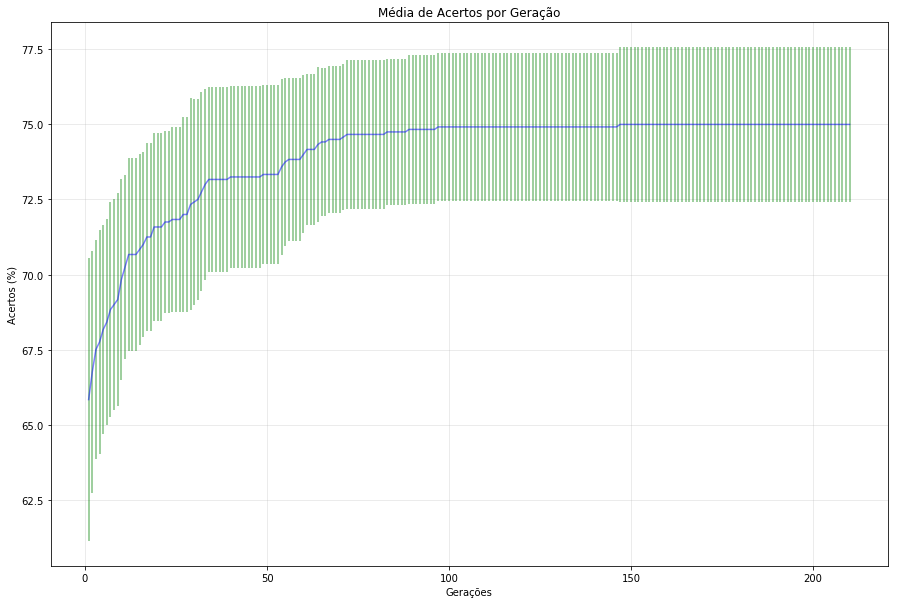

In [13]:
r11.plot()

In [78]:
print(np.random.choice(r11.population, 5))